# Research Assistant Agent Team : Creating Wikipedia-like articles from scratch with LLMs

This notebook implements this notebook using LangGraph:
- *Shao et al*, 2024. <a href="https://arxiv.org/pdf/2402.14207" target="_blank">Assisting in Writing Wikipedia-like Articles From Scratch
with Large Language Models</a>.


In [ ]:
# Research assistant

from dotenv import load_dotenv

load_dotenv("../.env")

True

In [ ]:
import os

PROJECT_NAME = "Research Assistant"

os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

In [ ]:
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

#llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

## Generate Agents (Analysts)

### Models and State

We will use a team of agents who will perform the research that we need. Each agent will be an expert in a specific field and will have a role, affiliation, and description. Creating a Model for the agents will help us query the LLM with structured output.
For example, if we wanted to research the topic of "The Apollo Missions", one of the agents could be a Space Exploration Engineer who is an expert in the technical aspects of the Apollo missions. Like this:

```json
{
  "Name": "Dr. John Lee",
  "Role": "Technical Expert",
  "Affiliation": "Space Exploration Engineer",
  "Description": "Concerned with the technical aspects of the Apollo missions, including the design and development of the spacecraft and rockets."
}
```

Let's create the model for the agents so we always have a structured output.

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
      description="Primary affiliation of the analyst"
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}"

class AnalystTeam(BaseModel):
    analysts: List[Analyst] = Field(
      description="List of analysts with their roles, affiliations, and descriptions."
    )

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_feedback: str
    analysts: List[Analyst]

### Nodes, edges and graph

We will create a graph that will generate the agents of the team. There will be two main nodes in this graph:
- Generate Analysts: Will generate the agents of the team given the topic of research.
- Human Feedback: Will receive feedback from the user about the agents generated. If there is any feedback, the graph will go back to the Generate Analysts node and generate a new team of agents.

In [ ]:
# generate the analysts node

from IPython.display import Image, display
from textwrap import dedent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

analyst_system_message = dedent("""
You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.
""")

def generate_analysts(state: GenerateAnalystsState) -> GenerateAnalystsState:
    topic = state.get('topic')
    max_analysts = state.get('max_analysts')
    human_feedback = state.get('human_feedback', '')

    prompt = ChatPromptTemplate.from_messages([
      ('system', analyst_system_message),
      ('human', 'Generate  set of analysts')
    ])

    structured_llm = llm.with_structured_output(AnalystTeam)

    chain = (prompt | structured_llm)

    result = chain.invoke({
      'topic': topic,
      'human_feedback': human_feedback,
      'max_analysts': max_analysts
    })

    return {"analysts": result.analysts}

In [ ]:
# test the generate_analysts node

TOPIC = "The effects of the Apollo Missions on Space Exploration"

test_state = GenerateAnalystsState(
  topic=TOPIC,
  max_analysts=3,
  human_feedback="",
  analysts=[]
)
analysts = generate_analysts(test_state)

for a in analysts['analysts']:
    print(a.persona)
    print("\n")

Name: Dr. Emily Carter
Role: Space Exploration Historian
Affiliation: NASA
Description: Dr. Carter specializes in the historical impact of space missions on technological advancements and public interest in space exploration. Her focus is on how the Apollo Missions inspired future generations of scientists and engineers.


Name: Prof. James Liu
Role: Astrophysics Researcher
Affiliation: MIT
Description: Prof. Liu conducts research on the scientific discoveries made during the Apollo Missions and their implications for future space exploration. He is particularly interested in the advancements in lunar science and how they have shaped our understanding of the solar system.


Name: Ms. Sarah Thompson
Role: Space Policy Analyst
Affiliation: Space Policy Institute
Description: Ms. Thompson analyzes the policy implications of the Apollo Missions on international space cooperation and funding for future missions. Her work focuses on how the Apollo program set the stage for collaborative effo

In [ ]:
# human feedback node (will interrupt the flow and ask for feedback)

def get_human_feedback(state: GenerateAnalystsState):
    pass

# edge
def should_continue(state: GenerateAnalystsState):
    """
    Check if there is human feedback. If there is, go back to generate_analysts, otherwise go to END.
    """
    human_feedback = state.get('human_feedback', None)
    if human_feedback:
        return "generate_analysts"
    else:
        return END

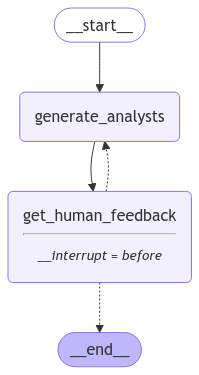

In [ ]:
# build graph

builder = StateGraph(GenerateAnalystsState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("get_human_feedback", get_human_feedback)

builder.add_edge(START, "generate_analysts")
builder.add_edge("generate_analysts", "get_human_feedback")
builder.add_conditional_edges("get_human_feedback", should_continue, ["generate_analysts", END])

# compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=["get_human_feedback"], checkpointer=memory)

# diagram
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Test the graph

Now it is time to test the graph. We will start by generating the agents for the topic "The Apollo Missions".
This will take us to the Human Feedback node where we can provide feedback on the agents generated. If we are not satisfied with the agents, we can go back to the Generate Analysts node and generate a new team of agents.

Note that it is very important to have enabled a checkpointer in the graph so we can re-run the graph on the same thread.

In [ ]:
# test the graph
THREAD_ID = "42"

max_analysts = 3
topic = "The Apollo Missions Impact on Space Exploration"
config = {"configurable": {"thread_id": THREAD_ID}}

for event in graph.stream(
  {"topic": topic,"max_analysts": max_analysts},
  config=config,
  stream_mode="values"):
    analysts = event.get('analysts', [])
    for a in analysts:
        print(a.persona)
        print("\n")

Name: Dr. Emily Carter
Role: Space Historian
Affiliation: NASA
Description: Dr. Carter specializes in the historical significance of space missions, focusing on how the Apollo program shaped modern space exploration policies and international cooperation.


Name: Prof. James Liu
Role: Astrophysicist
Affiliation: MIT
Description: Prof. Liu conducts research on the technological advancements stemming from the Apollo missions, analyzing their influence on current and future space exploration technologies.


Name: Dr. Sarah Thompson
Role: Sociologist of Science
Affiliation: Harvard University
Description: Dr. Thompson examines the societal impacts of the Apollo missions, including public perception of space exploration and its role in inspiring future generations of scientists and engineers.




In [ ]:
# check the state. we interrupted the flow before the human feedback node

state = graph.get_state(config=config)
state.next

('get_human_feedback',)

In [ ]:
# update the state with human feedback

HUMAN_FEEDBACK = "Replace Sarah with someone from ESA"

print("feedback:", HUMAN_FEEDBACK)

graph.update_state(
  config=config,
  values={"human_feedback": HUMAN_FEEDBACK},
  as_node="get_human_feedback")

feedback: Replace Sarah with someone from ESA


{'configurable': {'thread_id': '42',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6b31-d787-6760-8002-64c436b61c16'}}

In [ ]:
# what is next?

state = graph.get_state(config=config)
state.next

('generate_analysts',)

In [ ]:
# to continue with the graph execution, we rerun the graph with None as input state
for event in graph.stream(None, config=config, stream_mode="values"):
    print(event)
    print("-" * 20)

{'topic': 'The Apollo Missions Impact on Space Exploration', 'max_analysts': 3, 'human_feedback': 'Replace Sarah with someone from ESA', 'analysts': [Analyst(affiliation='NASA', name='Dr. Emily Carter', role='Space Historian', description='Dr. Carter specializes in the historical significance of space missions, focusing on how the Apollo program shaped modern space exploration policies and international cooperation.'), Analyst(affiliation='MIT', name='Prof. James Liu', role='Astrophysicist', description='Prof. Liu conducts research on the technological advancements stemming from the Apollo missions, analyzing their influence on current and future space exploration technologies.'), Analyst(affiliation='Harvard University', name='Dr. Sarah Thompson', role='Sociologist of Science', description='Dr. Thompson examines the societal impacts of the Apollo missions, including public perception of space exploration and its role in inspiring future generations of scientists and engineers.')]}
---

In [ ]:
# check the analysts now
state = graph.get_state(config=config)

for a in state.values.get('analysts'):
    print(a.persona)
    print("\n")

# next steps
print("Next step:", state.next)

Name: Dr. Emily Carter
Role: Space Policy Analyst
Affiliation: NASA
Description: Dr. Carter focuses on the policy implications of the Apollo Missions and their influence on current space exploration strategies. She is particularly interested in how historical missions shape international collaboration in space.


Name: Dr. Marco Rossi
Role: Space History Researcher
Affiliation: European Space Agency (ESA)
Description: Dr. Rossi specializes in the historical impact of the Apollo Missions on European space initiatives. He examines how these missions inspired ESA's programs and contributed to the development of European space technology.


Name: Ms. Jessica Lin
Role: Commercial Space Analyst
Affiliation: SpaceX
Description: Ms. Lin analyzes the commercial implications of the Apollo Missions on today's private space sector. She explores how the legacy of Apollo has influenced current commercial space endeavors and the future of human spaceflight.


Next step: ('get_human_feedback',)


In [ ]:
# remember that the conditional edge will go to end if we provide no feedback

HUMAN_FEEDBACK = None

print("feedback:", HUMAN_FEEDBACK)

graph.update_state(
  config=config,
  values={"human_feedback": HUMAN_FEEDBACK},
  as_node="get_human_feedback")

feedback: None


{'configurable': {'thread_id': '42',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6b37-19d8-6272-8004-7ae35c1a4344'}}

In [ ]:
# next steps

state = graph.get_state(config=config)
print("Next step:", state.next)

Next step: ()


In [ ]:
final_state = graph.get_state(config=config)
analysts = final_state.values.get('analysts', [])
for a in analysts:
    print(a.persona)
    print("\n")

Name: Dr. Emily Carter
Role: Space Policy Analyst
Affiliation: NASA
Description: Dr. Carter focuses on the policy implications of the Apollo Missions and their influence on current space exploration strategies. She is particularly interested in how historical missions shape international collaboration in space.


Name: Dr. Marco Rossi
Role: Space History Researcher
Affiliation: European Space Agency (ESA)
Description: Dr. Rossi specializes in the historical impact of the Apollo Missions on European space initiatives. He examines how these missions inspired ESA's programs and contributed to the development of European space technology.


Name: Ms. Jessica Lin
Role: Commercial Space Analyst
Affiliation: SpaceX
Description: Ms. Lin analyzes the commercial implications of the Apollo Missions on today's private space sector. She explores how the legacy of Apollo has influenced current commercial space endeavors and the future of human spaceflight.




## Interview

Now it is time to create the graph in charge of the interview process. Every agent will perform an interview with a "Specialist" in the topic of research. The agents will ask questions related to their field of expertise and the Specialist will answer them. The Specialist will have access to the internet and will be able to look up information if needed.

### Models and state

In [ ]:
# conduct interview

import operator
from typing import Annotated # to add the reducer
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_turns: int
    source_docs: Annotated[list, operator.add]
    analyst: Analyst
    interview_transcript: str
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    query: str = Field(None, description="Search query for retrieval")


### generate questions

In [ ]:

from textwrap import dedent
from langchain_core.prompts import MessagesPlaceholder
from langchain_openai import ChatOpenAI

question_prompt = dedent("""
You are an analyst tasked with interviewing an expert to learn about a specific topic.
Your goal is boil down to interesting and specific insights related to your topic.
1. Interesting: Insights that people will find surprising or non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and professional description: {analyst_persona}

Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic.
When you are satisfied with your understanding, complete the interview with: "INTERVIEW FINISHED"
Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
""")

def generate_question(state: InterviewState) -> InterviewState:
    analyst = state.get('analyst')
    messages = state.get('messages', [])

    prompt = ChatPromptTemplate.from_messages([
      ('system', question_prompt),
      MessagesPlaceholder(variable_name="conversation_history")
    ])

    #llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

    question = (prompt | llm).invoke({
      'conversation_history': messages,
      'analyst_persona': analyst.persona
    })

    question.name = "analyst"

    return {"messages": [question]}

### generate answers

In [ ]:
%pip install -Uq langchain-community wikipedia

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
import os
import getpass

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

tavily_search = TavilySearchResults(max_results=3)

#### nodes for web search and wikipedia search

In [ ]:
from langchain_core.messages import SystemMessage

search_query_prompt = dedent(
    """
You will be given a conversation between an analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query
"""
)


def search_web(state: InterviewState):
    messages = state.get('messages', [])

    # search query
    #llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SystemMessage(content=search_query_prompt)] + messages
    )

    # search
    web_search_results = tavily_search.invoke(search_query.query)

    if not isinstance(web_search_results, list):
        return {"source_docs": []}

    for i, result in enumerate(web_search_results):
        summarized = llm.invoke(
            f"""Summarize the following content into two detailed paragraphs. Be sure to include the main points and key details.
                This summary will be used to generate a structured query for further research:
                {result['content']}
                """
        )
        web_search_results[i]["content"] = summarized

    formatted_results = "\n\n---\n\n".join(
        [
            f'<Document href="{result['url']}">\n{result["content"]}\n</Document>'
            for result in web_search_results
        ]
    )

    return {"source_docs": [formatted_results]}


def search_wikipedia(state: InterviewState):
    # search query
    #llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SystemMessage(content=search_query_prompt)] + state["messages"]
    )

    # search
    wikipedia_results = WikipediaLoader(
        query=search_query.query, load_max_docs=2
    ).load()

    # we use the summary to reduce token usage, but you can use the full content in result.page_content
    formatted_results = "\n\n---\n\n".join(
        [
            f'<Document href="{result.metadata['source']}">\nTitle: {result.metadata['title']}\n\n{result.metadata['summary']}\n</Document>'
            for result in wikipedia_results
        ]
    )

    return {"source_docs": [formatted_results]}

In [ ]:
# test nodes

from langchain_core.messages import AIMessage

test_state = InterviewState(
  max_num_turns=2,
  source_docs=[],
  analyst=analysts[0],
  interview_transcript="",
  sections=[],
  messages=[
    SystemMessage(content="What is the impact of social media on mental health?"),
    AIMessage(content="I am an analyst from the University of California, Berkeley. I am interested in the impact of social media on mental health.", name="analyst"),
    AIMessage(content="What is the impact of social media on mental health?", name="analyst")
  ]
)

In [ ]:
wiki_results = search_wikipedia(test_state)

print(wiki_results['source_docs'][0])

<Document href="https://en.wikipedia.org/wiki/Social_media">
Title: Social media

Social media are interactive technologies that facilitate the creation, sharing and aggregation of content (such as ideas, interests, and other forms of expression) amongst virtual communities and networks. Common features include:

Online platforms that enable users to create and share content and participate in social networking.
User-generated content—such as text posts or comments, digital photos or videos, and data generated through online interactions.
Service-specific profiles that are designed and maintained by the social media organization.
Social media helps the development of online social networks by connecting a user's profile with those of other individuals or groups.
The term social in regard to media suggests platforms enable communal activity. Social media can enhance and extend human networks. Users access social media through web-based apps or custom apps on mobile devices. These intera

In [ ]:
web_results = search_web(test_state)

print (web_results['source_docs'][0])

<Document href="https://www.forbes.com/health/mind/social-media-and-mental-health/">
content="Sarah Hays Coomer, a National Board Certified Health and Wellness Coach, discusses the multifaceted effects of social media on mental health, highlighting both positive and negative aspects. On one hand, social media can foster connections and provide support networks, which can be beneficial for individuals seeking community and belonging. However, Coomer emphasizes the detrimental effects, such as increased feelings of anxiety, depression, and loneliness, often stemming from social comparison, cyberbullying, and the pressure to maintain a curated online persona. The constant exposure to idealized representations of others' lives can lead to unrealistic expectations and a diminished sense of self-worth, particularly among younger users who are more susceptible to these influences.\n\nTo mitigate the adverse effects of social media, Coomer offers practical advice for individuals looking to red

### Node for answering questions with sources

In [ ]:
from langchain_core.messages import get_buffer_string
from langchain_core.output_parsers import StrOutputParser

DEFAULT_MAX_TURNS = 2

answer_prompt = dedent(
    """
You are an expert being interviewed by an analyst.

Here is the analyst's area of focus: {analyst_persona}.

You goal is to answer a question posed by the interviewer.

To answer the question, you may use this context if relevant:

{source_docs}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources in your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="https://wikipedia.org/wiki/example"/>' then just list:

[1] https://wikipedia.org/wiki/example

And skip the addition of the brackets as well as the Document source preamble in your citation."""
)


def generate_answer(state: InterviewState):
    analyst = state.get("analyst")
    messages = state.get("messages", [])
    source_docs = state.get("source_docs", [])

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", answer_prompt),
            MessagesPlaceholder(variable_name="conversation_history"),
        ]
    )

    #llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

    answer = (prompt | llm).invoke(
        {
            "conversation_history": messages,
            "analyst_persona": analyst.persona,
            "source_docs": source_docs,
        }
    )

    answer.name = "expert"

    return {"messages": [answer]}


# conditional edge
def route_messages(state: InterviewState, name: str = "expert"):
    messages = state.get("messages", [])
    max_num_turns = state.get("max_num_turns", DEFAULT_MAX_TURNS)

    num_responses = len([m for m in messages if m.name == name])

    if num_responses >= max_num_turns:
        return "save_interview"

    last_question = messages[-2]

    if "INTERVIEW FINISHED" in last_question.content:
        return "save_interview"

    return "generate_question"


# node to save the interview
def save_interview(state: InterviewState):
    messages = state.get("messages", [])

    interview = get_buffer_string(messages)

    return {"interview_transcript": interview}


section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based
on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, within the
<Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{analyst_description}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


# node to write section
def write_section(state: InterviewState):
    interview = state.get("interview_transcript", "")
    source_docs = state.get("source_docs", [])
    analyst = state.get("analyst")

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", section_writer_instructions),
            ("human", "Use this information to write your section: {source_docs}"),
        ]
    )

    #llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.2)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

    chain = prompt | llm | StrOutputParser()

    section = chain.invoke(
        {"source_docs": source_docs, "analyst_description": analyst.description}
    )

    return {"sections": [section]}

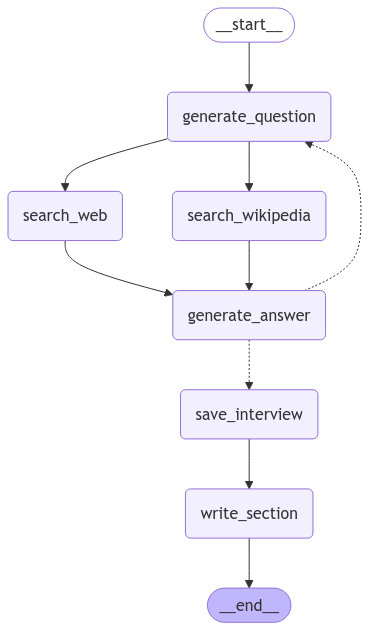

In [ ]:
# create graph
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# nodes
interview_graph_builder = StateGraph(InterviewState)
interview_graph_builder.add_node("generate_question", generate_question)
interview_graph_builder.add_node("search_web", search_web)
interview_graph_builder.add_node("search_wikipedia", search_wikipedia)
interview_graph_builder.add_node("generate_answer", generate_answer)
interview_graph_builder.add_node("save_interview", save_interview)
interview_graph_builder.add_node("write_section", write_section)

# edges
interview_graph_builder.add_edge(START, "generate_question")
interview_graph_builder.add_edge("generate_question", "search_web")
interview_graph_builder.add_edge("generate_question", "search_wikipedia")
interview_graph_builder.add_edge("search_web", "generate_answer")
interview_graph_builder.add_edge("search_wikipedia", "generate_answer")
interview_graph_builder.add_conditional_edges("generate_answer", route_messages, ["generate_question", "save_interview"])
interview_graph_builder.add_edge("save_interview", "write_section")
interview_graph_builder.add_edge("write_section", END)

# compile
memory = MemorySaver()
interview_graph = interview_graph_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

# view
display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))

## Test it with one analyst

In [ ]:
print(analysts[0].persona)

Name: Dr. Emily Carter
Role: Space Policy Analyst
Affiliation: NASA
Description: Dr. Carter focuses on the policy implications of the Apollo Missions and their influence on current space exploration strategies. She is particularly interested in how historical missions shape international collaboration in space.


In [ ]:
from IPython.display import Markdown
from langchain_core.messages import HumanMessage

topic = "The impact of the Apollo Missions on Space Exploration"
thread_id = "1"

messages = [HumanMessage(f"You are writing an article on {topic}. Right?")]
config = {"configurable": {"thread_id": thread_id}}
interview = interview_graph.invoke({
  "analyst": analysts[0],
  "messages": messages,
  "max_num_turns": DEFAULT_MAX_TURNS
  }, config)
Markdown(interview['sections'][0])

## The Enduring Legacy of the Apollo Missions: Shaping Future Space Exploration

### Summary
The Apollo missions, which successfully landed humans on the Moon, have left an indelible mark on contemporary space exploration strategies, particularly influencing NASA's Artemis program aimed at returning humans to the lunar surface. The technological advancements achieved during the Apollo era, including innovations in spacecraft design and navigation systems, have laid the groundwork for modern missions, ensuring safety and success in current endeavors. Notably, the Apollo program has transcended mere technological achievements; it has inspired a cultural shift towards science, technology, engineering, and mathematics (STEM) education, fostering a skilled workforce essential for tackling contemporary challenges in space exploration [1].

Moreover, the Apollo missions catalyzed a wave of entrepreneurial ventures in the space industry, exemplified by initiatives like Virgin Galactic, which aims to make space tourism accessible to private individuals. This shift towards commercial spaceflight underscores the Apollo program's role as a foundational platform for future innovations and projects, paving the way for a new era of exploration and development [2]. 

The Apollo missions also established a framework for international collaboration in space exploration. The partnerships formed during this period not only facilitated technological advancements but also fostered a spirit of unity among nations, setting a precedent for future collaborative efforts. The legacy of the Apollo missions continues to inspire global cooperation, as seen in projects like the International Space Station (ISS), which involves multiple countries working together for scientific research and technology development [3][4]. 

Interestingly, the Apollo-Soyuz mission in 1975 marked the first international space collaboration, demonstrating the feasibility and benefits of joint efforts in space exploration. This spirit of collaboration has become increasingly vital as nations navigate the complexities of modern space endeavors, emphasizing the importance of teamwork and shared goals [5]. 

In summary, the Apollo missions not only reshaped our understanding of the Moon and its relationship with Earth but also instilled an optimistic vision for the future of space exploration, where international cooperation remains a crucial element in humanity's quest to explore the cosmos [6].

### Sources
[1] https://apollo11space.com/the-essence-and-significance-of-the-apollo-program/  
[2] https://apollo11space.com/apollos-impact-assessing-the-value-of-moon-missions/  
[3] https://moon-mission.info/international-collaborations-in-apollo-missions-a-close-look/  
[4] https://apollo11space.com/how-the-apollo-program-shaped-international-relations/  
[5] https://newspaceeconomy.ca/2023/11/14/global-collaboration-in-space-benefits-and-challenges/  
[6] https://en.wikipedia.org/wiki/Artemis_I  

## Paralelize Interviews with Map-Reduce

In [ ]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    report_intro: str # Introduction for the final report
    report_content: str # Content for the final report
    report_conclusion: str # Conclusion for the final report
    report_final: str # Final report

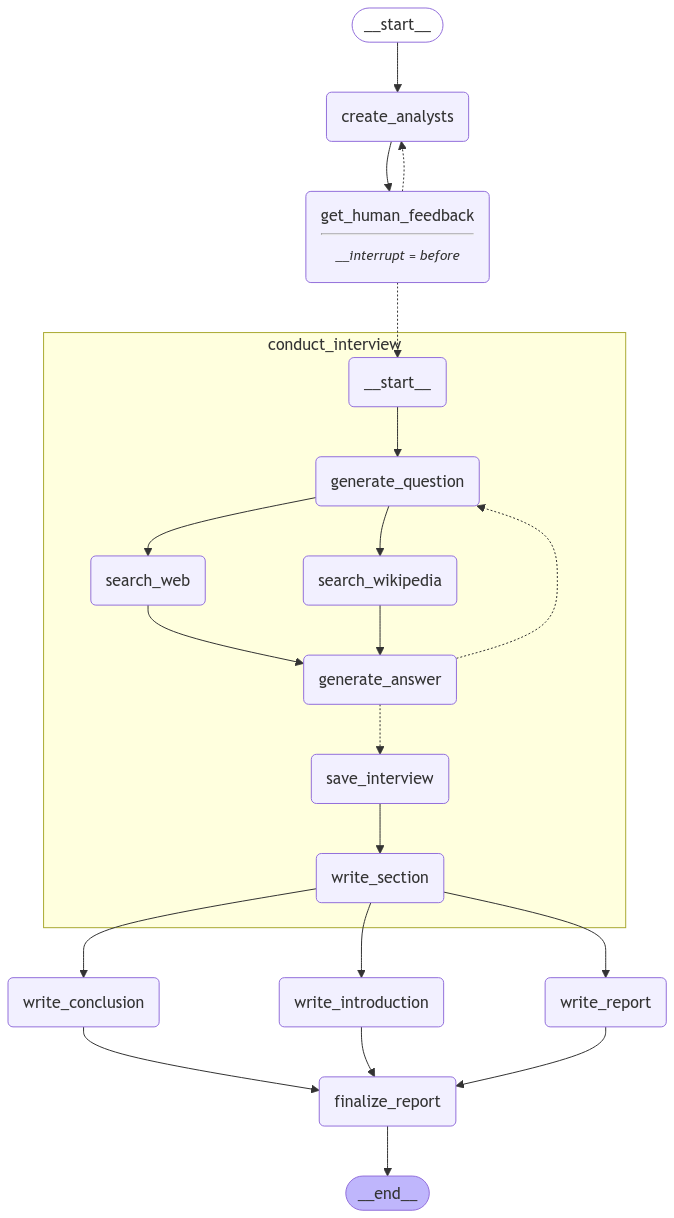

In [ ]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"report_content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"report_intro": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"report_conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["report_content"]
    intro = state["report_intro"]
    conclusion = state["report_conclusion"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = intro + "\n\n---\n\n" + content + "\n\n---\n\n" + conclusion
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"report_final": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", generate_analysts)
builder.add_node("get_human_feedback", get_human_feedback)
builder.add_node("conduct_interview", interview_graph_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "get_human_feedback")
builder.add_conditional_edges("get_human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["get_human_feedback"])
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Inputs
max_analysts = 3
topic = "the effects of the apollo missions on space exploration"
config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          config,
                          stream_mode="values"):

    print(event)
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

{'topic': 'the effects of the apollo missions on space exploration', 'max_analysts': 3, 'sections': []}
{'topic': 'the effects of the apollo missions on space exploration', 'max_analysts': 3, 'analysts': [Analyst(affiliation='NASA', name='Dr. Emily Carter', role='Space Exploration Historian', description='Dr. Carter specializes in the historical impact of space missions on technological advancements and international collaboration in space exploration. Her focus is on how the Apollo missions set the stage for future missions and influenced global space policies.'), Analyst(affiliation='MIT', name='Prof. James Liu', role='Astrophysicist', description='Prof. Liu examines the scientific breakthroughs resulting from the Apollo missions, particularly in astrophysics and planetary science. He is interested in how these missions expanded our understanding of the Moon and other celestial bodies, and their implications for future exploration.'), Analyst(affiliation='Space Policy Institute', nam

In [ ]:
graph.get_state(config=config).next

('get_human_feedback',)

In [ ]:
# We now update the state as if we are the human_feedback node
graph.update_state(config, {"human_feedback":
                                "replace one with someone from the ESA"}, as_node="get_human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb550f-cc55-6f82-8002-539f9f4e7007'}}

In [ ]:
# Check
for event in graph.stream(None, config, stream_mode="values"):
    print(event)
    print("-" * 20)

{'topic': 'the effects of the apollo missions on space exploration', 'max_analysts': 3, 'human_feedback': 'replace one with someone from the ESA', 'analysts': [Analyst(affiliation='NASA', name='Dr. Emily Carter', role='Space Exploration Historian', description='Dr. Carter specializes in the historical impact of space missions on technological advancements and international collaboration in space exploration. Her focus is on how the Apollo missions set the stage for future missions and influenced global space policies.'), Analyst(affiliation='MIT', name='Prof. James Liu', role='Astrophysicist', description='Prof. Liu examines the scientific breakthroughs resulting from the Apollo missions, particularly in astrophysics and planetary science. He is interested in how these missions expanded our understanding of the Moon and other celestial bodies, and their implications for future exploration.'), Analyst(affiliation='Space Policy Institute', name='Dr. Sarah Thompson', role='Space Policy An

In [ ]:
# Confirm we are config
graph.update_state(config, {"human_feedback":
                            None}, as_node="get_human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb550f-f692-6c1e-8004-d69ec9e72636'}}

In [ ]:
# Continue
for event in graph.stream(None, config, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [ ]:
from IPython.display import Markdown
final_state = graph.get_state(config)
report = final_state.values.get('report_final')
Markdown(report)

# The Apollo Missions: A Catalyst for Future Exploration

## Introduction

The Apollo program, culminating in the historic Apollo 11 mission, represents a watershed moment in human space exploration, achieving the first manned Moon landing in 1969. This report delves into the enduring legacy of the Apollo missions, examining their profound impact on modern space exploration, international collaboration, and scientific advancement. We explore how Apollo not only inspired global interest in space but also fostered technological innovations that permeate various industries today. Additionally, we highlight the program's influence on contemporary initiatives like Artemis and the lessons learned that continue to shape the future of human spaceflight.

---


The Apollo missions, particularly the landmark Apollo 11 mission, represent a transformative chapter in human space exploration, achieving the first successful manned Moon landing in 1969. This monumental event not only showcased the feasibility of human space travel but also sparked a wave of technological advancements and international collaborations that continue to shape space exploration today. The Apollo program ignited a renewed global interest in space, leading to significant investments in space programs worldwide and fostering a spirit of innovation that transcended national borders.

The technological innovations developed during the Apollo missions, such as advancements in materials science, telecommunications, and robotics, have had far-reaching applications beyond space exploration, revolutionizing industries from aviation to medicine. The Apollo program has also had a lasting cultural impact, inspiring generations of scientists, engineers, and astronauts, and contributing to increased enrollment in STEM fields. The legacy of Apollo is evident in contemporary initiatives like NASA's Artemis program, which aims to return humans to the Moon and eventually send astronauts to Mars. The lessons learned from Apollo, particularly regarding safety and rigorous testing protocols, have become foundational to modern space missions.

Moreover, the Apollo missions played a crucial role in fostering international collaboration in space exploration. They established a framework for cooperation among nations that had previously been rivals in the space race. The partnerships formed during this era demonstrated the potential for shared resources, expertise, and technology to lead to groundbreaking achievements. The Apollo-Soyuz mission in 1975 symbolized a new era of peaceful collaboration between the United States and the Soviet Union, reinforcing the importance of international partnerships in advancing space exploration.

The ripple effect of the Apollo program inspired countries like France, Japan, and China to enhance their own space initiatives, leading to increased funding and the establishment of new space agencies. The collaborative spirit fostered by the Apollo missions continues to resonate in contemporary space endeavors, informing strategies for joint missions and resource sharing. However, the landscape of global collaboration is not without challenges, as political dynamics and varying levels of investment can complicate partnerships.

The scientific legacy of the Apollo missions is profound, having significantly advanced our understanding of the Moon and the broader dynamics of our solar system. The return of lunar materials allowed for in-depth analyses of the Moon's geology, revealing critical insights into its composition and the geological processes that shaped its surface over billions of years. This foundational research has laid the groundwork for future explorations and continues to inspire ongoing inquiries into planetary science.

As we reflect on the Apollo Program, it is clear that its influence extends beyond space exploration; it has shaped societal attitudes towards science and technology, reinforcing the importance of continued investment in these areas. The lessons learned from the Apollo missions highlight the significance of ambition, collaboration, and perseverance in the quest for knowledge about our universe. The Apollo missions not only set a benchmark for human spaceflight but also established a framework for future exploration endeavors, reminding us that collective efforts can lead to extraordinary accomplishments.


---

## Conclusion

The Apollo missions stand as a monumental achievement in human history, fundamentally transforming the landscape of space exploration. From the groundbreaking Apollo 11 mission that first landed humans on the Moon to the international collaborations fostered during the Apollo-Soyuz mission, the program established a legacy of innovation and cooperation. The technological advancements and scientific insights gained from lunar exploration have not only enriched our understanding of the Moon but have also laid the groundwork for contemporary initiatives like the Artemis program. As we look to the future, the spirit of ambition, collaboration, and resilience that characterized the Apollo era continues to inspire new generations and guide our quest for knowledge beyond our planet.

## Sources
[1] https://library.fiveable.me/key-terms/ap-world/apollo-11-mission  
[2] https://moon-mission.info/exploring-the-apollo-program-past-and-present-impacts/  
[3] https://apollo11space.com/apollo-programs-impact-science-society-and-space-exploration/  
[4] https://en.wikipedia.org/wiki/Apollo_program  
[5] https://en.wikipedia.org/wiki/Artemis_II  
[6] https://ntrs.nasa.gov/api/citations/20120013187/downloads/20120013187.pdf  
[7] https://apollo11space.com/the-apollo-1-tragedy-a-look-back-at-the-fateful-mission/  
[8] https://en.wikipedia.org/wiki/Apollo_1  
[9] https://en.wikipedia.org/wiki/Apollo_13  
[10] https://moon-mission.info/international-collaborations-in-apollo-missions-a-close-look/  
[11] https://www.thespacereview.com/article/3328/1  
[12] https://newspaceeconomy.ca/2023/11/14/global-collaboration-in-space-benefits-and-challenges/  
[13] https://apollo11space.com/how-the-apollo-program-shaped-international-relations/  
[14] https://apollo11space.com/how-did-the-apollo-missions-impact-science/  
[15] https://pubs.aip.org/physicstoday/article/72/7/44/982029/The-scientific-legacy-of-the-Apollo-programThis  
[16] https://en.wikipedia.org/wiki/Apollo_16  
[17] https://en.wikipedia.org/wiki/Sample-return_missio